# CS 20 : TensorFlow for Deep Learning Research
## Lecture 11 : Recurrent Neural Networks
Simple example for Many to One Classification (word sentiment classification) by Recurrent Neural Networks. 

### Many to One Classification by RNN
- Creating the **data pipeline** with `tf.data`
- Preprocessing word sequences (variable input sequence length) using `padding technique` by `user function (pad_seq)`
- Using `tf.nn.embedding_lookup` for getting vector of tokens (eg. word, character)
- Creating the model as **Class**
- Reference
    - https://github.com/golbin/TensorFlow-Tutorials/blob/master/10%20-%20RNN/02%20-%20Autocomplete.py
    - https://github.com/aisolab/TF_code_examples_for_Deep_learning/blob/master/Tutorial%20of%20implementing%20Sequence%20classification%20with%20RNN%20series.ipynb


### Setup

In [1]:
import os, sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import string
%matplotlib inline

slim = tf.contrib.slim
print(tf.__version__)

1.8.0


### Prepare example data

In [2]:
words = ['good', 'bad', 'amazing', 'so good', 'bull shit', 'awesome']
y = [[1.,0.], [0.,1.], [1.,0.], [1., 0.],[0.,1.], [1.,0.]]

In [3]:
# Character quantization
char_space = string.ascii_lowercase 
char_space = char_space + ' ' + '*'
char_space

'abcdefghijklmnopqrstuvwxyz *'

In [4]:
char_dic = {char : idx for idx, char in enumerate(char_space)}
print(char_dic)

{'a': 0, 'b': 1, 'c': 2, 'd': 3, 'e': 4, 'f': 5, 'g': 6, 'h': 7, 'i': 8, 'j': 9, 'k': 10, 'l': 11, 'm': 12, 'n': 13, 'o': 14, 'p': 15, 'q': 16, 'r': 17, 's': 18, 't': 19, 'u': 20, 'v': 21, 'w': 22, 'x': 23, 'y': 24, 'z': 25, ' ': 26, '*': 27}


### Create pad_seq function

In [5]:
def pad_seq(sequences, max_len, dic):
    seq_len, seq_indices = [], []
    for seq in sequences:
        seq_len.append(len(seq))
        seq_idx = [dic.get(char) for char in seq]
        seq_idx += (max_len - len(seq_idx)) * [dic.get('*')] # 27 is idx of meaningless token "*"
        seq_indices.append(seq_idx)
    return seq_len, seq_indices

### Apply pad_seq function to data

In [6]:
max_length = 10
X_length, X_indices = pad_seq(sequences = words, max_len = max_length, dic = char_dic)

In [7]:
print(X_length)
print(np.shape(X_indices))

[4, 3, 7, 7, 9, 7]
(6, 10)


### Define CharRNN class

In [8]:
class CharRNN:
    def __init__(self, X_length, X_indices, y, n_of_classes, hidden_dim, dic):
        
        # data pipeline
        with tf.variable_scope('input_layer'):
            self._X_length = X_length
            self._X_indices = X_indices
            self._y = y
            
            one_hot = tf.eye(len(dic), dtype = tf.float32)
            self._one_hot = tf.get_variable(name='one_hot_embedding', initializer = one_hot,
                                            trainable = False) # embedding vector training 안할 것이기 때문
            self._X_batch = tf.nn.embedding_lookup(params = self._one_hot, ids = self._X_indices)    
        
        # RNN cell
        with tf.variable_scope('rnn_cell'):
            rnn_cell = tf.contrib.rnn.BasicRNNCell(num_units = hidden_dim, activation = tf.nn.tanh)
            _, state = tf.nn.dynamic_rnn(cell = rnn_cell, inputs = self._X_batch,
                                         sequence_length = self._X_length, dtype = tf.float32)
            
        with tf.variable_scope('output_layer'):
            self._score = slim.fully_connected(inputs = state, num_outputs = n_of_classes, activation_fn = None)
            
        with tf.variable_scope('loss'):
            self.ce_loss = tf.losses.softmax_cross_entropy(onehot_labels = self._y, logits = self._score)
            
        with tf.variable_scope('prediction'):
            self._prediction = tf.argmax(input = self._score, axis = -1, output_type = tf.int32)
    
    def predict(self, sess, X_length, X_indices):
        feed_prediction = {self._X_length : X_length, self._X_indices : X_indices}
        return sess.run(self._prediction, feed_dict = feed_prediction)

### Create a model of CharRNN

In [9]:
# hyper-parameter#
lr = .003
epochs = 10
batch_size = 2
total_step = int(np.shape(X_indices)[0] / batch_size)
print(total_step)

3


In [10]:
## create data pipeline with tf.data
tr_dataset = tf.data.Dataset.from_tensor_slices((X_length, X_indices, y))
tr_dataset = tr_dataset.shuffle(buffer_size = 20)
tr_dataset = tr_dataset.batch(batch_size = batch_size)
tr_iterator = tr_dataset.make_initializable_iterator()
print(tr_dataset)

<BatchDataset shapes: ((?,), (?, 10), (?, 2)), types: (tf.int32, tf.int32, tf.float32)>


In [11]:
X_length_mb, X_indices_mb, y_mb = tr_iterator.get_next()

In [12]:
char_rnn = CharRNN(X_length = X_length_mb, X_indices = X_indices_mb, y = y_mb, n_of_classes = 2,
                   hidden_dim = 16, dic = char_dic)

### Creat training op and train model

In [13]:
## create training op
opt = tf.train.AdamOptimizer(learning_rate = lr)
training_op = opt.minimize(loss = char_rnn.ce_loss)

In [14]:
sess = tf.Session()
sess.run(tf.global_variables_initializer())

tr_loss_hist = []

for epoch in range(epochs):
    avg_tr_loss = 0
    tr_step = 0
    
    sess.run(tr_iterator.initializer)
    try:
        while True:
            _, tr_loss = sess.run(fetches = [training_op, char_rnn.ce_loss])
            avg_tr_loss += tr_loss
            tr_step += 1
            
    except tf.errors.OutOfRangeError:
        pass
    
    avg_tr_loss /= tr_step
    tr_loss_hist.append(avg_tr_loss)
    
    print('epoch : {:3}, tr_loss : {:.3f}'.format(epoch + 1, avg_tr_loss))

epoch :   1, tr_loss : 0.665
epoch :   2, tr_loss : 0.609
epoch :   3, tr_loss : 0.569
epoch :   4, tr_loss : 0.517
epoch :   5, tr_loss : 0.476
epoch :   6, tr_loss : 0.427
epoch :   7, tr_loss : 0.381
epoch :   8, tr_loss : 0.338
epoch :   9, tr_loss : 0.285
epoch :  10, tr_loss : 0.240


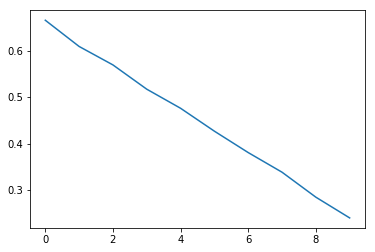

In [15]:
plt.plot(tr_loss_hist, label = 'train')

In [16]:
yhat = char_rnn.predict(sess = sess, X_length = X_length, X_indices = X_indices)

In [17]:
print('training acc: {:.2%}'.format(np.mean(yhat == np.argmax(y, axis = -1))))

training acc: 100.00%
